In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_zurich/train/merger/587736942527643944.jpeg  
  inflating: dataset_zurich/train/merger/588007004191588455.jpeg  
  inflating: dataset_zurich/train/merger/587738953106849840.jpeg  
  inflating: dataset_zurich/train/merger/587739721898328168.jpeg  
  inflating: dataset_zurich/train/merger/588007004191785072.jpeg  
  inflating: dataset_zurich/train/merger/588023045865603121.jpeg  
  inflating: dataset_zurich/train/merger/587736541474914354.jpeg  
  inflating: dataset_zurich/train/merger/587733081346605093.jpeg  
  inflating: dataset_zurich/train/merger/587736525374750812.jpeg  
  inflating: dataset_zurich/train/merger/587739720305213625.jpeg  
  inflating: dataset_zurich/train/merger/587726033328930880.jpeg  
  inflating: dataset_zurich/train/merger/587725041170055202.jpeg  
  inflating: dataset_zurich/train/merger/587736619324014666.jpeg  
  inflating: dataset_zurich/train/merger/587739408377970846.jpeg  
  inflating

In [3]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=bfa0e481b7cb9d4288bb75ee0a46334bcf951bb3b3b787417760c03aafa52838
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [4]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

import pretrainedmodels.utils as utils

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

In [7]:
import pretrainedmodels

In [8]:
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [9]:
# Import xception pre-trained model
model_name = 'xception' # could be fbresnet152 or inceptionresnetv2
model_conv = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model_conv.eval()
tf_img = utils.TransformImage(model_conv)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [10]:
data_transforms = tf_img

In [ ]:
# data_dir = "/content/dataset_zurich"
# types = ["train", "val", "test"]
# transform_types = ["train", "val"]  # Do not transform the test set (since it is not learned)

# batch_size = 8 # Smaller batch sizes are better for generalization to test set
# shuffle = True
# num_workers = 1

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in transform_types}
# image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms)  # Do not transform test set, only load it. 

# dataloaders = {x: torch.utils.data.DataLoader(
#                 image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
#               }

# dataset_sizes = {x: len(image_datasets[x]) for x in types}
# class_names = image_datasets['train'].classes

In [11]:
# Preparing dataset for Stratified Sampling.

import shutil
os.mkdir("train_val")
os.mkdir("train_val/noninteracting")
os.mkdir("train_val/merger")

src_train_merger = "dataset_zurich/train/merger/"
src_val_merger = "dataset_zurich/val/merger/"
src_train_noninteracting = "dataset_zurich/train/noninteracting/"
src_val_noninteracting = "dataset_zurich/val/noninteracting/"

dest_merger = "train_val/merger/"
dest_noninteracting = "train_val/noninteracting/"

for filename in os.listdir(src_train_merger):
  shutil.move(os.path.join(src_train_merger, filename), dest_merger)
for filename in os.listdir(src_val_merger):
  shutil.move(os.path.join(src_val_merger, filename), dest_merger)

for filename in os.listdir(src_train_noninteracting):
  shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
for filename in os.listdir(src_val_noninteracting):
  shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)

# shutil.move("dataset_zurich/train/merger/*", "train_val/merger")
# shutil.move("dataset_zurich/train/noninteracting/*", "train_val/noninteracting")
# shutil.move("dataset_zurich/val/merger/*", "train_val/merger")
# shutil.move("dataset_zurich/val/noninteracting/*", "train_val/noninteracting")

In [12]:
dataset = torchvision.datasets.ImageFolder("train_val", transform=data_transforms)
targets = dataset.targets

In [13]:
from sklearn.model_selection import train_test_split

train_idx, valid_idx = train_test_split(
                          np.arange(len(targets)),
                          test_size=0.2,
                          shuffle=True,
                          stratify=targets
                      )

In [14]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

batch_size = 8 # Smaller batch sizes are better for generalization to test set
num_workers = 1

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler
)
valid_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, num_workers=num_workers, sampler=valid_sampler
)
# Note: shuffle and sampler cannot be used together, they are mutually exclusive.

In [15]:
test_dataset = datasets.ImageFolder(os.path.join("dataset_zurich", "test"), data_transforms)
shuffle = True
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [16]:
dataloaders = {"train": train_loader, "val": valid_loader, "test": test_loader}

In [17]:
class_names = ["merger", "noninteracting"]

In [18]:
types = ["train", "val", "test"]
dataset_sizes = {"train": len(train_idx), "val": len(valid_idx), "test": len(test_dataset)}

In [19]:
dataset_sizes

{'test': 3998, 'train': 9601, 'val': 2401}

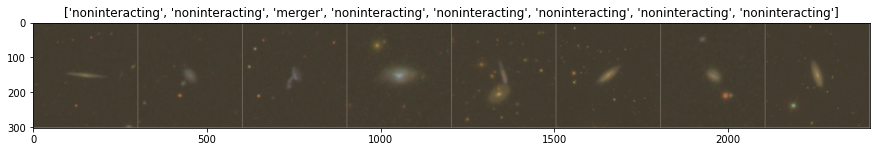

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(15, 40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
merger_count = 0
noninteracting_count = 0

for sample in train_loader.dataset.samples:
  if "merger" in sample[0]:
    merger_count += 1
  elif "noninteracting" in sample[0]:
    noninteracting_count += 1
print(merger_count)
print(noninteracting_count)

4502
7500


In [22]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase =="train":
              train_losses.append(epoch_loss)
            elif phase == "val":
              valid_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
# Hyperparameters from the paper (A1. Main Experiment)
n_epochs = 40
lr = 0.001
momentum = None

In [25]:
# model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.last_linear.in_features
model_conv.last_linear = nn.Linear(num_ftrs, 2)
# model_conv.last_linear_ = nn.Linear(int(num_ftrs/4), 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.last_linear.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
model_conv

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [27]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model_conv.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_conv.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

20,811,050 total parameters.
4,098 training parameters.


In [28]:
model_conv, train_losses, valid_losses = train_model(model_conv, criterion, optimizer_conv, num_epochs=n_epochs)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5615 Acc: 0.7089
val Loss: 0.5112 Acc: 0.7522

Epoch 1/39
----------
train Loss: 0.5181 Acc: 0.7457
val Loss: 0.4686 Acc: 0.7763

Epoch 2/39
----------
train Loss: 0.5159 Acc: 0.7424
val Loss: 0.4743 Acc: 0.7730

Epoch 3/39
----------
train Loss: 0.5053 Acc: 0.7606
val Loss: 0.4669 Acc: 0.7843

Epoch 4/39
----------
train Loss: 0.4869 Acc: 0.7654
val Loss: 0.4797 Acc: 0.7747

Epoch 5/39
----------
train Loss: 0.4979 Acc: 0.7646
val Loss: 0.4467 Acc: 0.7968

Epoch 6/39
----------
train Loss: 0.4967 Acc: 0.7598
val Loss: 0.4474 Acc: 0.7976

Epoch 7/39
----------
train Loss: 0.4936 Acc: 0.7629
val Loss: 0.4745 Acc: 0.7668

Epoch 8/39
----------
train Loss: 0.4883 Acc: 0.7665
val Loss: 0.4636 Acc: 0.7876

Epoch 9/39
----------
train Loss: 0.4850 Acc: 0.7693
val Loss: 0.4548 Acc: 0.7972

Epoch 10/39
----------
train Loss: 0.4882 Acc: 0.7691
val Loss: 0.4776 Acc: 0.7755

Epoch 11/39
----------
train Loss: 0.4832 Acc: 0.7696
val Loss: 0.4554 Acc: 0.7893

Epoch 12/39
----------
t

In [29]:
torch.save(model_conv.state_dict(), "xception_40epochs_adam_latest.pth")

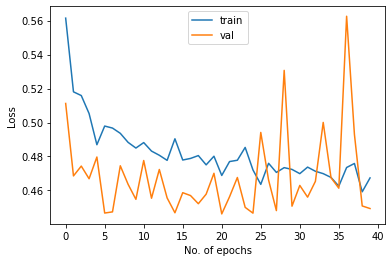

In [39]:
plt.plot(train_losses, label="train");
plt.plot(valid_losses, label="val");

plt.xlabel("No. of epochs");
plt.ylabel("Loss");
plt.legend();

Due to the rapid movements of loss after around 20 epochs, it might be a good idea to decay the learning rate using a `lr_scheduler`. This seems to be commonly done in transfer learning.

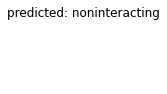

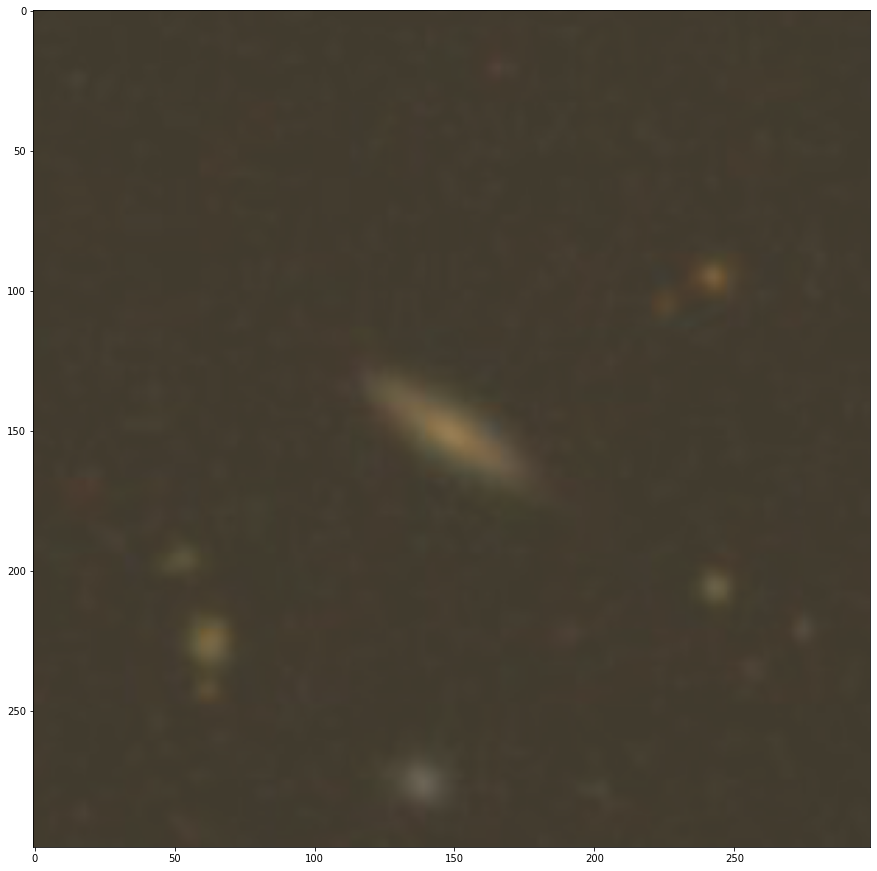

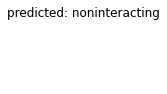

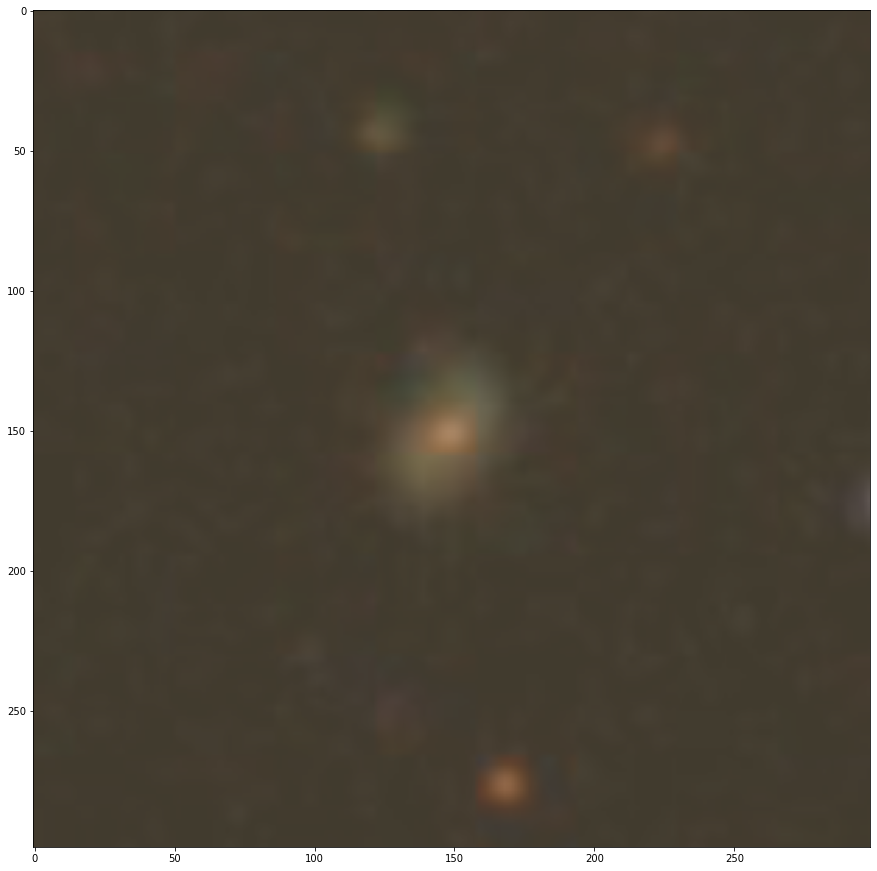

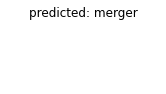

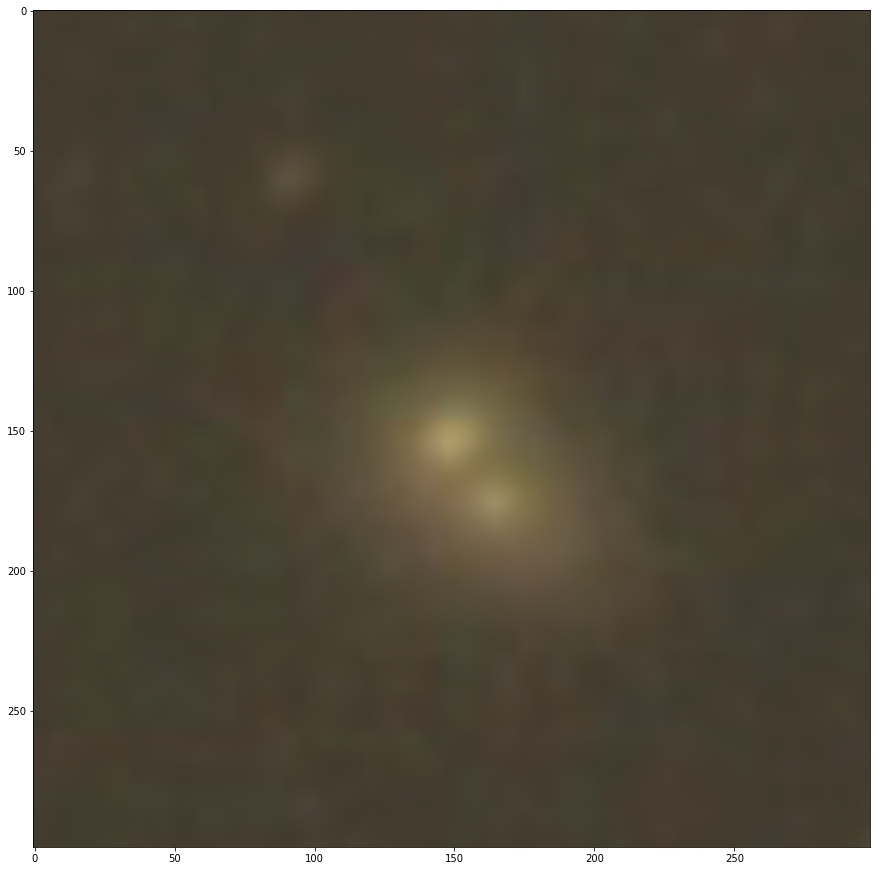

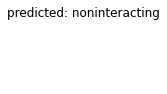

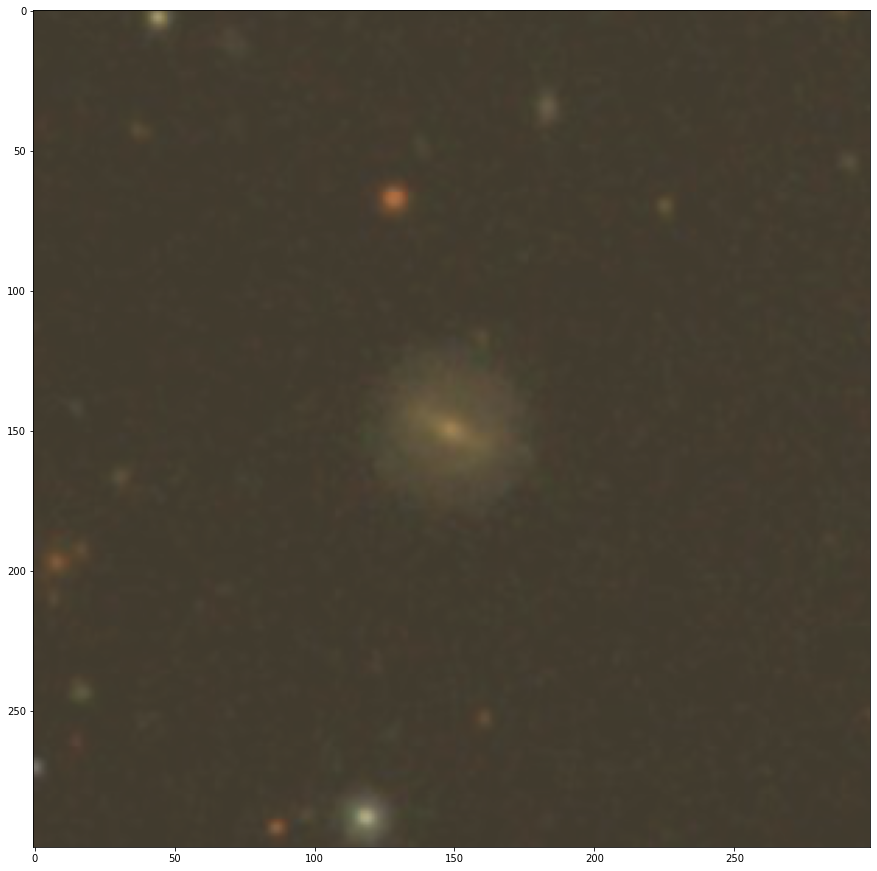

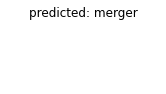

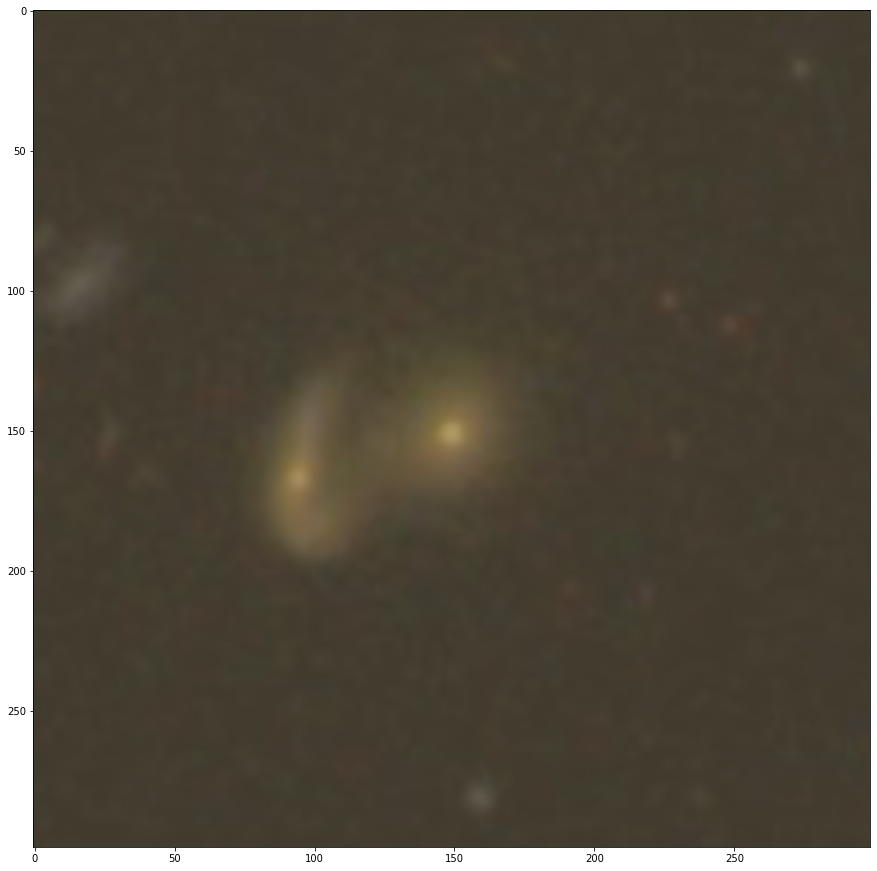

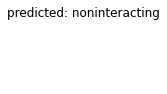

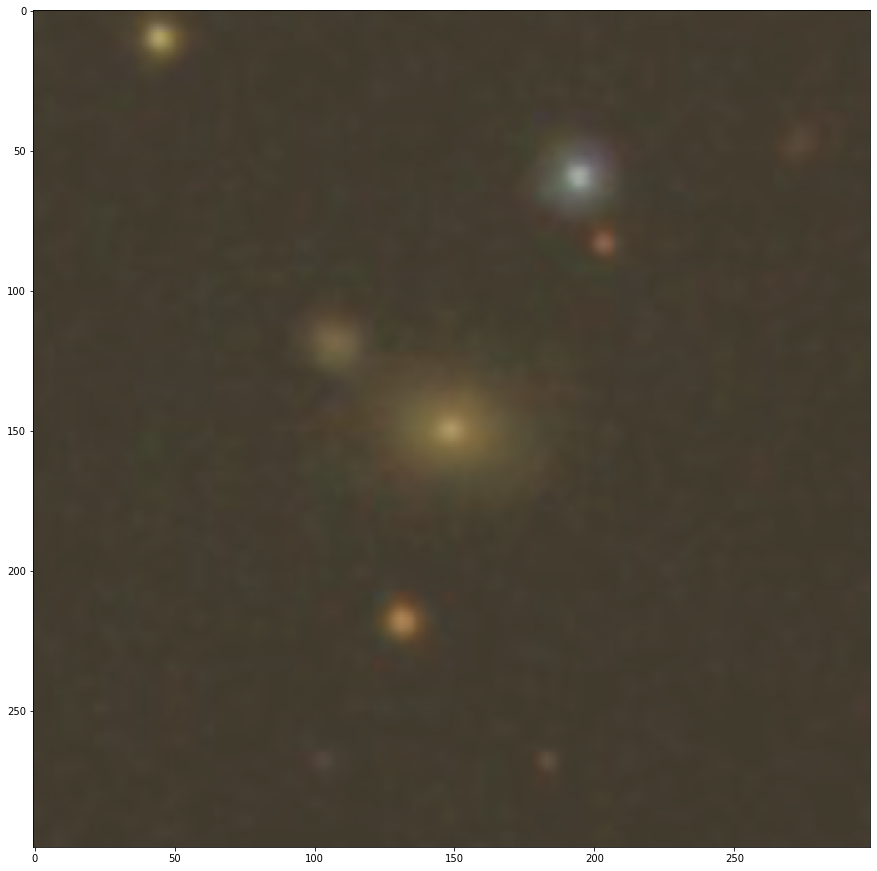

In [30]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [85]:
inps, labels_ = next(iter(test_loader))
print(labels_)

tensor([0, 0, 0, 0, 0, 1, 1, 0])


In [88]:
test_loader.dataset.classes

['merger', 'noninteracting']

In [93]:
len(targets_[targets_ == 1])

2500

In [40]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []

model_conv.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model_conv(inputs)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 78.53926963481742


In [41]:
print(f"Accuracy: {correct/total}")

Accuracy: 0.7853926963481741


**Note**: `0` means merger and `1` means non-interacting

In [42]:
for pred in all_preds:
  pred = pred.cpu().numpy()

In [43]:
preds = np.hstack([pred.cpu().numpy() for pred in all_preds])
targets_ = np.hstack([target_.cpu().numpy() for target_ in all_targets])

In [44]:
!pip install plot-metric

In [45]:
from plot_metric.functions import BinaryClassification

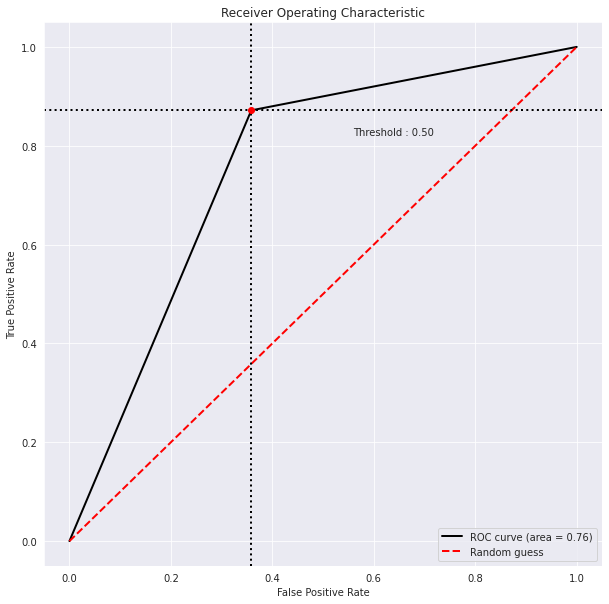

In [46]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
conf_matrix = confusion_matrix(targets_, preds)
print(conf_matrix)

[[ 961  537]
 [ 321 2179]]


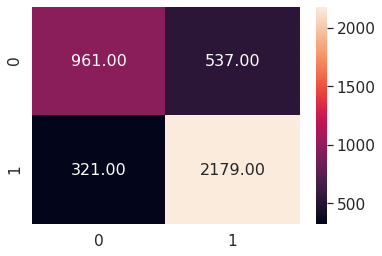

In [49]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".2f") # font size

plt.show()

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [51]:
precision = precision_score(targets_, preds, average='binary')
recall = recall_score(targets_, preds, average='binary')
f1_score = f1_score(targets_, preds, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.8022827687776142
Recall: 0.8716
F1 Score: 0.8355061349693251


In [52]:
outs

[tensor([[ 0.8067, -0.7684],
         [-1.1336,  0.9226],
         [-0.3182,  0.2846],
         [ 0.1198, -0.1404],
         [ 2.1567, -2.2841],
         [-0.9959,  0.9406],
         [ 0.2568, -0.4263],
         [-1.0364,  0.9530]], device='cuda:0'), tensor([[-2.0161,  2.0646],
         [-1.1151,  1.1988],
         [-1.2114,  1.2439],
         [-1.4450,  1.3608],
         [ 0.3229, -0.5673],
         [-1.4273,  1.4845],
         [ 1.9081, -1.8931],
         [-1.0912,  1.0323]], device='cuda:0'), tensor([[ 1.0562, -1.0280],
         [ 0.1077, -0.0628],
         [-0.8158,  0.7755],
         [-0.7076,  0.5849],
         [-0.1012,  0.2108],
         [-1.6990,  1.7973],
         [-2.3672,  2.3056],
         [-0.2906,  0.2213]], device='cuda:0'), tensor([[-1.4454,  1.4753],
         [-1.3492,  1.1036],
         [-1.0475,  0.9913],
         [ 2.1580, -2.0947],
         [ 0.1605, -0.2470],
         [ 1.0594, -1.2158],
         [-0.8000,  0.8325],
         [-1.1785,  1.1487]], device='cuda:0'),

The variable `outputs` are the outputs of the deep convolutional network. To get the probabilites of prediction, we need to apply a sigmoid activation on these.

In [57]:
output_probs_list = [torch.sigmoid(outs[i]) for i in range(len(outs))]

In [62]:
outputs_1 = [tensor_output.cpu().numpy() for tensor_output in output_probs_list]

In [64]:
outputs_2 = np.vstack([out_1 for out_1 in outputs_1])

In [68]:
outputs_2.shape

(3998, 2)

In [69]:
outputs_2

array([[0.69141614, 0.316824  ],
       [0.24349304, 0.7155752 ],
       [0.42112377, 0.57066274],
       ...,
       [0.46065643, 0.56451607],
       [0.6262731 , 0.43038747],
       [0.37582433, 0.6258972 ]], dtype=float32)

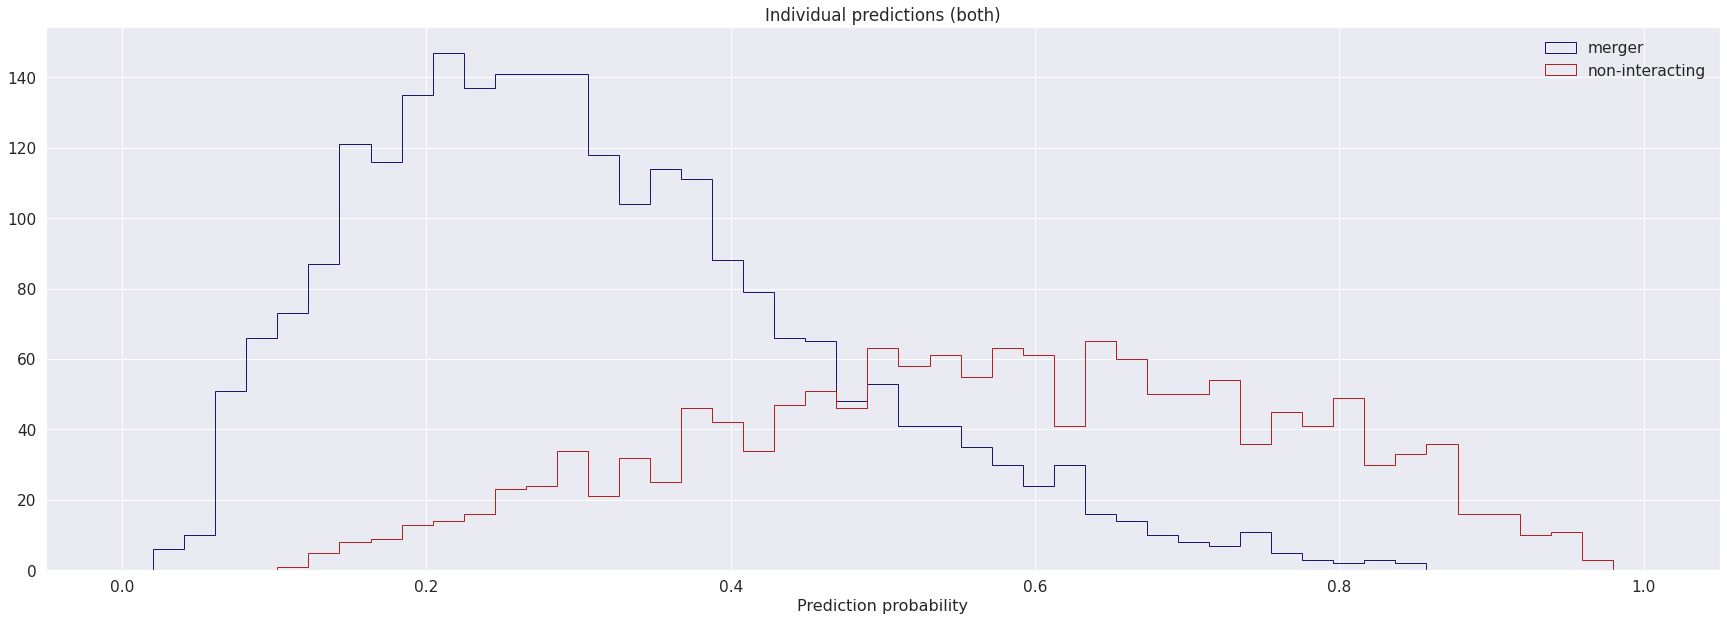

In [94]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 10));

hist_style_all = dict(histtype="step", color="darkgreen", label="All")
hist_style_class1 = dict(histtype="step", color="midnightblue", label="merger")
hist_style_class2 = dict(histtype="step", color="firebrick", label="non-interacting")

# ax1.hist(preds, bins=np.linspace(0, 1, 50), **hist_style_all);

# ax1.set_xlabel("Prediction", fontsize=16);
# ax1.set_ylabel("", fontsize=16);
# ax1.set_title("Individual predictions (both)");
# ax1.legend(frameon=False);

ax.hist(outputs_2[:, 0][targets_.astype(bool)], bins=np.linspace(0, 1, 50),
        **hist_style_class1);
ax.hist((1 - outputs_2[:, 1])[~(targets_.astype(bool))], bins=np.linspace(0, 1, 50),
        **hist_style_class2);

ax.set_xlabel("Prediction probability", fontsize=16);
ax.set_ylabel("", fontsize=16);
ax.set_title("Individual predictions (both)")
ax.legend(frameon=False);

In [ ]:
outs_last_excluded = np.hstack([out.cpu().numpy() for out in outs[:-1]])

In [ ]:
final_outs = np.hstack([ans for ans in outs_last_excluded])

In [ ]:
outs = [out.cpu().numpy() for out in outs]

In [ ]:
answer = [np.hstack(outs[i][:, 0]) for i in range(len(outs))]

In [ ]:
class_1_raw_preds = np.hstack([ans for ans in answer])

In [ ]:
answer2 = [np.hstack(outs[i][:, -1]) for i in range(len(outs))]

In [ ]:
class_2_raw_preds = np.hstack([ans for ans in answer2])

In [ ]:
class_22_raw_preds = 1 - class_2_raw_preds

In [ ]:
# c1 = np.abs(class_1_raw_preds)
# c2 = np.abs(class_2_raw_preds)

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10));

# hist_style_all = dict(histtype="step", color="darkgreen", label="All")
# hist_style_class1 = dict(histtype="step", color="midnightblue", label="merger")
# hist_style_class2 = dict(histtype="step", color="firebrick", label="non-interacting")

# # ax1.hist(preds, bins=np.linspace(0, 1, 50), **hist_style_all);

# # ax1.set_xlabel("Prediction", fontsize=16);
# # ax1.set_ylabel("", fontsize=16);
# # ax1.set_title("Individual predictions (both)");
# # ax1.legend(frameon=False);

# ax[0].hist(c1[targets_.astype(bool)], bins=np.linspace(0, 1, 50),
#         **hist_style_class1);
# ax[0].hist(c2[~(targets_.astype(bool))], bins=np.linspace(0, 1, 50),
#         **hist_style_class2);

# ax[0].set_xlabel("Prediction", fontsize=16);
# ax[0].set_ylabel("", fontsize=16);
# ax[0].set_title("Individual predictions (both)")
# ax[0].legend(frameon=False);

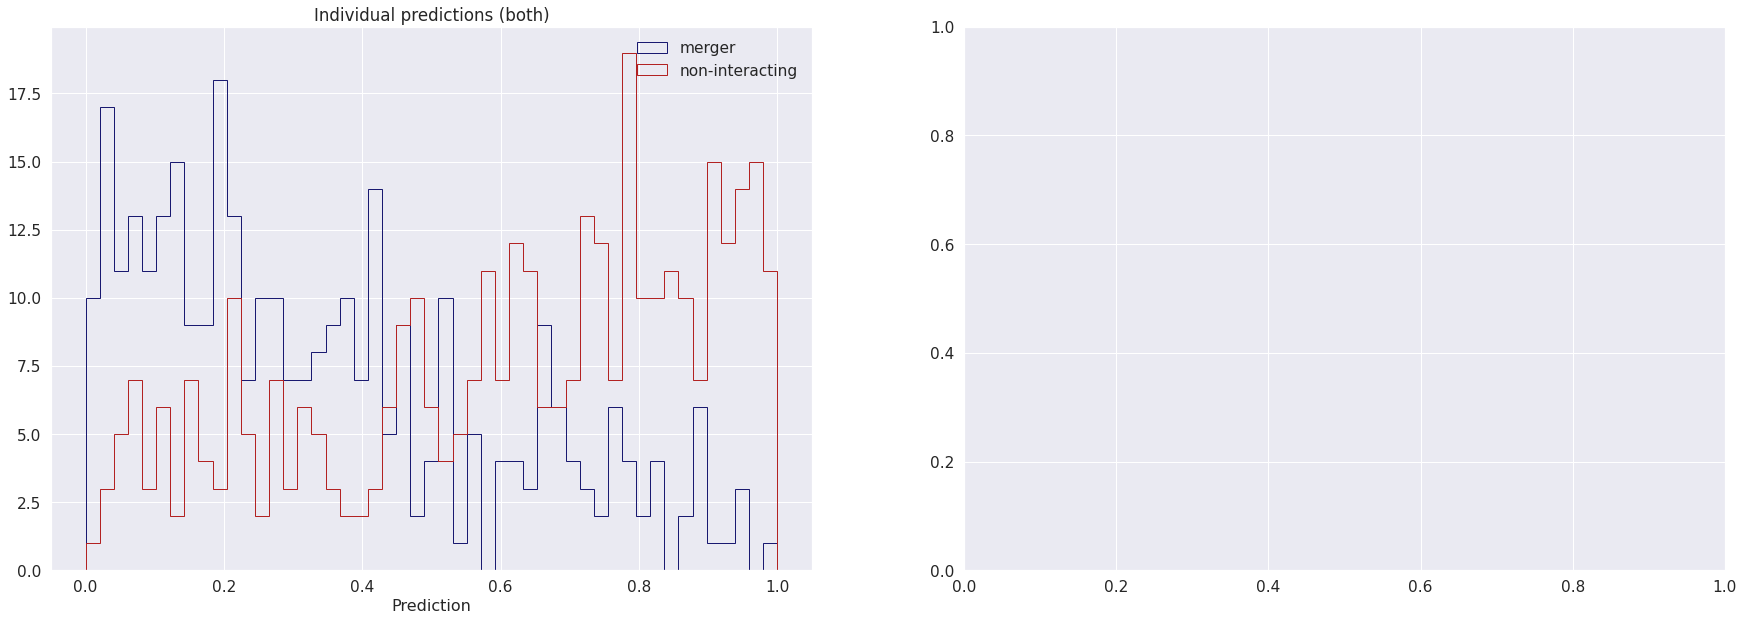

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10));

hist_style_all = dict(histtype="step", color="darkgreen", label="All")
hist_style_class1 = dict(histtype="step", color="midnightblue", label="merger")
hist_style_class2 = dict(histtype="step", color="firebrick", label="non-interacting")

# ax1.hist(preds, bins=np.linspace(0, 1, 50), **hist_style_all);

# ax1.set_xlabel("Prediction", fontsize=16);
# ax1.set_ylabel("", fontsize=16);
# ax1.set_title("Individual predictions (both)");
# ax1.legend(frameon=False);

ax[0].hist(class_1_raw_preds[targets_.astype(bool)], bins=np.linspace(0, 1, 50),
        **hist_style_class1);
ax[0].hist(class_22_raw_preds[~(targets_.astype(bool))], bins=np.linspace(0, 1, 50),
        **hist_style_class2);

ax[0].set_xlabel("Prediction", fontsize=16);
ax[0].set_ylabel("", fontsize=16);
ax[0].set_title("Individual predictions (both)")
ax[0].legend(frameon=False);

In [ ]:
!ls dataset_zurich/test/merger | wc -l

1498


In [ ]:
!ls dataset_zurich/test/noninteracting | wc -l

2500


In [ ]:
!ls dataset_zurich/train/merger | wc -l

3003


In [ ]:
!ls dataset_zurich/train/noninteracting | wc -l

5000


In [ ]:
!ls dataset_zurich/val/merger | wc -l

1499


In [ ]:
!ls dataset_zurich/val/noninteracting | wc -l

2500
